In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [48]:
import numpy as np
import pandas as pd

In [49]:
from datetime import datetime as dt
from datetime import timedelta, date

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [51]:
# reflect an existing database into a new model
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [54]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [55]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [56]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [57]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = dt.strptime(str(last_date[0]), '%Y-%m-%d') - timedelta(days = 365)
last_year

datetime.datetime(2016, 8, 23, 0, 0)

In [60]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > last_year).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results)
results_df.set_index("date", inplace=True)
results_df

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


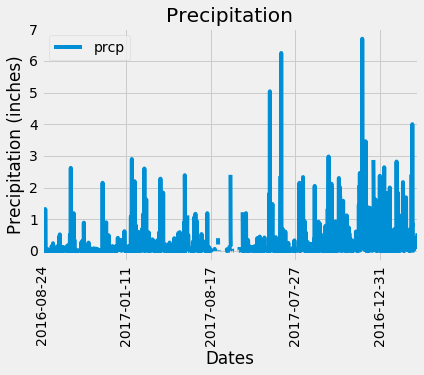

In [61]:
# Sort the dataframe by date
results_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
prcp_chart = results_df.plot(rot=90, title = "Precipitation")
prcp_chart.set_xlabel("Dates")
prcp_chart.set_ylabel("Precipitation (inches)")
plt.show()

In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [63]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first().station
most_active_station_info = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_station_info

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

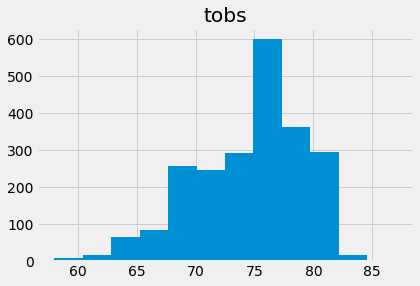

In [66]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_station_last_date = session.query(Measurement.date).filter(Measurement.station == most_active_station).order_by(Measurement.date.desc()).first()
highest_station_last_year = dt.strptime(str(highest_station_last_date[0]), '%Y-%m-%d') - timedelta(days = 365)
highest_station_results = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date > highest_station_last_year).all()
highest_station_df = pd.DataFrame(highest_station_results)
highest_station_chart = highest_station_df.hist(bins=12)
plt.show()

## Bonus Challenge Assignment

In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = "2012-08-03"
trip_start_date_last_year = dt.strptime(trip_start_date, '%Y-%m-%d') - timedelta(days = 365)
trip_end_date = "2012-08-10"
trip_end_date_last_year = dt.strptime(trip_end_date, '%Y-%m-%d') - timedelta(days = 365)

trip_temp_info = calc_temps(trip_start_date_last_year, trip_end_date_last_year)

print(trip_temp_info)

[(70.0, 75.94, 80.0)]


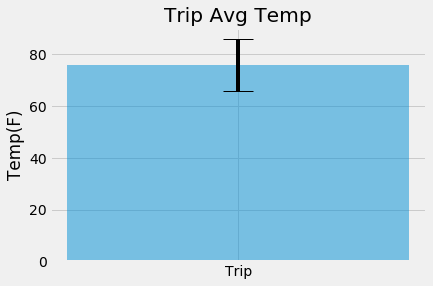

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

(t_min, t_avg, t_max) = trip_temp_info[0]
peak_to_peak = t_max - t_min

fig, ax = plt.subplots()
ax.bar("Trip", t_avg, yerr=peak_to_peak, alpha=0.5, ecolor='black', capsize=15)
ax.set_ylabel('Temp(F)')
ax.set_title('Trip Avg Temp')
plt.show()

In [70]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_rainfall = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date == trip_start_date_last_year.date()).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
trip_start_rainfall

[('USC00516128', 0.26, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 0.12, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 0.03, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519397', 0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830', 0.01, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [71]:
trip_end_rainfall = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date == trip_end_date_last_year.date()).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
trip_end_rainfall

[('USC00516128', 0.16, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 0.06, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [72]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [73]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = dt.strptime("2012-08-03", '%Y-%m-%d')
trip_end_date = dt.strptime("2012-08-10", '%Y-%m-%d')

# Use the start and end date to create a range of dates
trip_date_difference = (trip_end_date - trip_start_date).days
trip_dates = [(trip_start_date + timedelta(days=i)) for i in range(trip_date_difference + 1)]

# Stip off the year and save a list of %m-%d strings
stripped_trip_dates = [dt.strftime(date, "%m-%d") for date in trip_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in stripped_trip_dates]

tmin = [tmin for (tmin, tavg, tmax) in [normal[0] for normal in normals]]
tavg = [round(tavg,1) for (tmin, tavg, tmax) in [normal[0] for normal in normals]]
tmax = [tmax for (tmin, tavg, tmax) in [normal[0] for normal in normals]]

In [74]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame({"Min Temp": tmin, "Avg Temp": tavg, "Max Temp": tmax})
normals_df["Date"] = trip_dates
normals_df.set_index("Date", inplace = True)
normals_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2012-08-03,70.0,76.6,85.0
2012-08-04,69.0,76.7,84.0
2012-08-05,69.0,76.1,82.0
2012-08-06,67.0,76.2,83.0
2012-08-07,71.0,77.2,83.0
2012-08-08,68.0,76.6,83.0
2012-08-09,69.0,76.0,81.0
2012-08-10,65.0,76.4,83.0


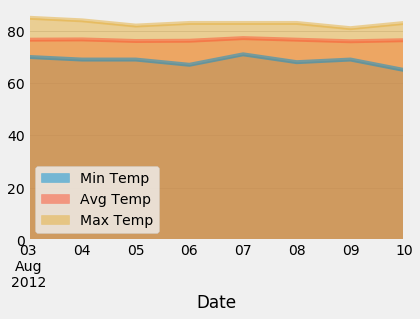

In [75]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.show()